<a href="https://colab.research.google.com/github/TerranceRandolph/Data-Analysis/blob/master/IST_718_BigData_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Terrance Randolph**
> *Lab 3: Coach Salary*

> *Big Data IST 718*






In [0]:
pip install fuzzymatcher

In [0]:
import os
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import fuzzymatcher # matching colleges based on prob.
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # interactive graphing lib.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

##**Read Data**

In [0]:
root_path = 'gdrive/My Drive/Village 3A/Big Data/Lab 3/'  #change dir to your project folder
# read in files and check is path is valid and its been loaded properly
stadium_cap_csv = root_path + 'stdcap.csv'   ; print('stadium_cap', os.path.exists( stadium_cap_csv ))
grad_rate_csv   = root_path + 'GSR.csv'      ; print('grad_rate', os.path.exists( grad_rate_csv ))
income_don_csv  = root_path + 'DonerStud.csv'; print('income_don', os.path.exists( income_don_csv ))
coach_sal_csv   = root_path + 'Coaches9.csv' ; print('coach_sal', os.path.exists( coach_sal_csv ))


In [0]:
# read CSV's into pandas
stadium_cap = pd.read_csv(stadium_cap_csv, encoding="windows-1252")
grad_rate   = pd.read_csv(grad_rate_csv, encoding="windows-1252")
income_don  = pd.read_csv(income_don_csv, encoding="windows-1252")
coach_sal   = pd.read_csv(coach_sal_csv, encoding="windows-1252")


In [0]:
# creat dataframe for CSVs
stadium_cap_df = pd.DataFrame(stadium_cap)
grad_rate_df   = pd.DataFrame(grad_rate)
income_don_df  = pd.DataFrame(income_don)
coach_sal_df   = pd.DataFrame(coach_sal)

In [38]:
# put dataframes in list to be interated through
ls = [stadium_cap_df, grad_rate_df, income_don_df, coach_sal_df]
for i in ls:
  # loop through each file to understand basic stats and structure of df
  print('----- HEAD -----\n',      i.head(),'\n')
  print('----- DISCRIBE ------\n', i.describe(),'\n')
  print('------ COL NAMES -----\n',i.columns,'\n')
  print('------ COL DATA TYPES -----\n',i.dtypes,'\n')
  print(20 * '---','\n\n\n')

----- HEAD -----
                     Stadium  ...                        Surface
0    Aggie Memorial Stadium  ...            S5-M Synthetic Turf
1        Albertsons Stadium  ...                     Smurf Turf
2  Allen E. Paulson Stadium  ...  Shaw Legion 41 Synthetic Turf
3             Aloha Stadium  ...                      FieldTurf
4            Alumni Stadium  ...                      AstroTurf

[5 rows x 6 columns] 

----- DISCRIBE ------
             Capacity
count     110.000000
mean    52734.327273
std     23611.140664
min     17000.000000
25%     30878.500000
50%     50035.500000
75%     65004.000000
max    107601.000000 

------ COL NAMES -----
 Index(['Stadium', 'City', 'State', 'School', 'Capacity', 'Surface'], dtype='object') 

------ COL DATA TYPES -----
 Stadium     object
City        object
State       object
School      object
Capacity     int64
Surface     object
dtype: object 

------------------------------------------------------------ 



----- HEAD -----
        

##**Clean Data**
###***What schools did we drop from our data, and why?*** 

*   Air Force Academy and others are Private schools and Military schools. Therefore, the GSR dataset does not having access to information from those schools due to their institutional policies.



*   Military schools. Therefore, the GSR dataset does not having access to information from those schools due to their institutional policies.
o	Alternatively, Baylor and Southern Methodist was removed due a lack of coach’s salary data. Also, a few more institutions were disregarded because of their lack of high matching probability during the fuzzy matching process.


In [39]:
# rename columns of df's 
stadium_cap_df.columns  = ['Stadium','City','State',
                           'School','Capacity','Surface']
grad_rate_df.columns    = ['School','HBCU',
                           'FedGradRate','GradRate']
income_don_df.columns   = ['School','DonorCash','StudenFees']
coach_sal_df.columns    = ['School','Conference','Coach','SchoolPay',
                           'TotalPay','Bonus','BonusPaid','AssistantPay','Buyout']

# replace discretize Historic Black College distinction
grad_rate_df['HBCU'].replace([1, 2], ['yes','no'], inplace=True)
grad_rate_df.head()

,School,HBCU,FedGradRate,GradRate
0,Alabama A & M University,yes,43,47
1,University of Alabama at Birmingham,no,57,66
2,Alabama State University,yes,37,89
3,The University of Alabama,no,70,92
4,Auburn University,no,65,80


In [0]:
# remove all null if they are in columns of intrest
income   = income_don_df[income_don_df['DonorCash'].notnull()]
sdCap    = stadium_cap_df[stadium_cap_df['Capacity'].notnull()]
gradRate = grad_rate_df[grad_rate_df['GradRate'].notnull()]
coSal    = coach_sal_df[coach_sal_df['TotalPay'].notnull()]


##***Merge & Match Data Frames: Fuzzy

In [0]:
def mergeFuzzy(tbl1,tbl2):
  # fuzzy mactch based on best prob from list
  join_L = ['School']; join_R = ['School']
  # merge the datasets together; print head of joined dataframe
  mTbl = fuzzymatcher.fuzzy_left_join(tbl1, tbl2,join_L, join_R)
  # make best_match_score column numeric
  mTbl['best_match_score'] = mTbl['best_match_score'].apply(pd.to_numeric)
  # remove all matches below prob of 20%
  index = mTbl[mTbl['best_match_score'] < 0.02].index
  mTbl.drop(index, inplace=True)
  # remove uneeded columns
  mTbl.drop(['best_match_score','__id_left',
             '__id_right', 'School_left'],axis =1, inplace = True)
  # rename the right join School col var name back to School
  mTbl = mTbl.rename(columns = {'School_right':'School'})
  return(mTbl)

In [40]:
# merge pair resoning: both tables don't university in school name majority of time
m1 = mergeFuzzy(sdCap, coSal); m1.head()
# merge pair resoning: both tables have university in school name majority of time
m2 = mergeFuzzy(income, gradRate); m2.head()
# Final Merge and remove all N/A in relevent columns
m3 = mergeFuzzy(m1, m2); m3.head()
coachSalary = m3[m3['School'].notnull()] ; coachSalary.head()

,Stadium,City,State,Capacity,Surface,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,DonorCash,StudenFees,School,HBCU,FedGradRate,GradRate
0,Aggie Memorial Stadium,Las Cruces,NM,30343,S5-M Synthetic Turf,Ind.,Doug Martin,419640.0,419640.0,220000.0,20000.0,0.0,1532790.0,1455064.0,1795434.0,New Mexico State University-Main Campus,no,67.0,80.0
1,Albertsons Stadium,Boise,ID,36387,Smurf Turf,Mt. West,Bryan Harsin,1650010.0,1650010.0,475000.0,145000.0,0.0,7784038.0,2771494.0,2401225.0,Boise State University,no,51.0,65.0
2,Allen E. Paulson Stadium,Statesboro,GA,25000,Shaw Legion 41 Synthetic Turf,Sun Belt,Chad Lunsford,650000.0,650000.0,295000.0,NaN,0.0,83333.0,796301.0,3943739.0,Georgia Southern University,no,64.0,68.0
17,Apogee Stadium,Denton,TX,30850,PowerBlade Artificial Turf,C-USA,Seth Littrell,1425000.0,1425000.0,580000.0,130000.0,0.0,4425000.0,1494883.0,4275375.0,University of North Texas,no,67.0,80.0
18,Arizona Stadium,Tucson,AZ,56029,FieldTurf,Pac-12,Kevin Sumlin,1600000.0,2000000.0,2025000.0,NaN,0.0,10000000.0,11362200.0,0.0,University of Arizona,no,64.0,78.0


In [41]:
coachSalary['ConfNum'] = pd.factorize(coachSalary['Conference'])[0] + 1
coachSalary['Conference'].value_counts() ; coachSalary['ConfNum'].value_counts()
# discretize Conference & School for Regression
coachSalary = coachSalary.assign(SchoolNum = [i[0] for i in enumerate(coachSalary['School'])])

# what percentage of the endowment and School tuition can be accounted for in 
# --- > the Coaches TotalPay?
# Add Student/Donor money
# get percentage of TotalPay to Student Pay
PctBudgetCoach = round(coachSalary['TotalPay'] / (coachSalary['DonorCash'] + coachSalary['StudenFees']) * 100)
coachSalary = coachSalary.assign(PctBudgetCoach = PctBudgetCoach)
coachSalary.loc[(coachSalary.PctBudgetCoach >= 150),'PctBudgetCoach']=150
coachSalary.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Stadium,City,State,Capacity,Surface,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,DonorCash,StudenFees,School,HBCU,FedGradRate,GradRate,ConfNum,SchoolNum,PctBudgetCoach
0,Aggie Memorial Stadium,Las Cruces,NM,30343,S5-M Synthetic Turf,Ind.,Doug Martin,419640.0,419640.0,220000.0,20000.0,0.0,1532790.0,1455064.0,1795434.0,New Mexico State University-Main Campus,no,67.0,80.0,1,0,13.0
1,Albertsons Stadium,Boise,ID,36387,Smurf Turf,Mt. West,Bryan Harsin,1650010.0,1650010.0,475000.0,145000.0,0.0,7784038.0,2771494.0,2401225.0,Boise State University,no,51.0,65.0,2,1,32.0
2,Allen E. Paulson Stadium,Statesboro,GA,25000,Shaw Legion 41 Synthetic Turf,Sun Belt,Chad Lunsford,650000.0,650000.0,295000.0,NaN,0.0,83333.0,796301.0,3943739.0,Georgia Southern University,no,64.0,68.0,3,2,14.0
17,Apogee Stadium,Denton,TX,30850,PowerBlade Artificial Turf,C-USA,Seth Littrell,1425000.0,1425000.0,580000.0,130000.0,0.0,4425000.0,1494883.0,4275375.0,University of North Texas,no,67.0,80.0,4,3,25.0
18,Arizona Stadium,Tucson,AZ,56029,FieldTurf,Pac-12,Kevin Sumlin,1600000.0,2000000.0,2025000.0,NaN,0.0,10000000.0,11362200.0,0.0,University of Arizona,no,64.0,78.0,5,4,18.0


In [0]:
# exported to visually check for errors, fesable on small datasets
#coachSalary.to_csv(r'{0}coachSalary_Clean.csv'.format(root_path), index = False)

#**Exploritory Data Analysis**

##**Graduation Rate by Conference**
### Notice how the few HBCU's has the largest spread of graduation success rates

In [26]:
fig = px.box(coachSalary, x='Conference', y='GradRate', color="HBCU",
             title="Graduation Rate by Conference")
fig.show()

###HBCU's are leading the trend of high coach salary

In [27]:
fig = px.box(coachSalary, x='Conference', y='TotalPay', color="HBCU",
             title="CoachSalary by Conference")
fig.show()

##**Stadium capacity and coaches salary by conference**
###Stadium seems to play a significant role in coaches salary, but their may be a larger relationship between conference and coachs' salary.

In [30]:

bar1 = px.bar(coachSalary, x = 'Conference', y = 'TotalPay',
             hover_data=['School','Coach'], color='Capacity',
             labels={'Coach Salary'}, height=400)
bar1.show()

### Donor Cash is fairly low conpared to coach salary meaning an increase in donor cash is not significant enough to impact pay.

In [31]:
bar2 = px.bar(coachSalary, x = 'Conference', y = 'TotalPay',
             hover_data=['School','Coach'], color='DonorCash',
             labels={'Coach Salary'}, height=400)
bar2.show()

## **GSR compared to the percentage of salary to donor contributions/student fees**
###GSR density is between 65% - 90% with coaches salary holding at less than 50% indicating no significant relationships

In [35]:
scat1 = px.scatter(coachSalary, x='GradRate', y='PctBudgetCoach',
                              color = 'Conference',size = 'Capacity')
scat1.show()

In [34]:
scat2 = px.scatter(coachSalary, x='FedGradRate', y='PctBudgetCoach',
                              color = 'Conference',size = 'Capacity')
scat2.show()

# **Training Testing Split at 70% ---  30%**

In [0]:
##################################################################

# create training-and-test regimen for model validation
np.random.seed(1234)
coachSalary['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(coachSalary))
coachSalary_train = coachSalary[coachSalary['runiform'] >= 0.30]
coachSalary_test = coachSalary[coachSalary['runiform'] < 0.30]
# check training data frame
print('\ncoachSalary_train data frame (rows, columns): ',coachSalary_train.shape)
print(coachSalary_train.head())
# check test data frame
print('\ncoachSalary_test data frame (rows, columns): ',coachSalary_test.shape)
print(coachSalary_test.head())

##################################################################

## **Build OLS Regression Model**
###***How good is our model? What is the single biggest impact on salary size?***


*   The Ordinary Least Squares Regression is a Liner regression model that minimized the errors and it minimizes the error of prediction from the regression line. Therefore, the coach’s salary is the Y- dependent variable with X being the explanatory variables and epsilon as the error or residuals from regression line to predicted salary.



> ![OLS Equation](https://drive.google.com/uc?id=1vUIe0vF_4Av4pJ4mWsPzDXidJkIkkBT1)



*   The model can confidently account for (.78) the variability in the regression which is the R-squared. Meaning, the suggested coefficients or rather magnitude of the independent X-variables have on the Y-dependent variable accuracy is beholden to that R-square.


*   Therefore, based on the p-values (assumption of alpha being 0.95) the strongest correlation is school stadium capacity with a p-value well below (0.000). Moreover, the coefficient of (62) indicates that for every seat in the stadium the head coach salary will increase by $62.



In [22]:
##################################################################

# simple model --- GradRate = R-sqr 0.788
my_model = str('TotalPay ~ Capacity + ConfNum + DonorCash + StudenFees + FedGradRate + GradRate')
# simple model --- remove ConfNum, FedGradRate and GradRate  = R-sqr 0.776
#my_model = str('TotalPay ~ Capacity +  DonorCash + StudenFees')

###################################################################

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = coachSalary_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
coachSalary_train['predict_salary'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
coachSalary_test['predict_salary'] = train_model_fit.predict(coachSalary_test)

##################################################################

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     31.64
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.49e-15
Time:                        01:07:31   Log-Likelihood:                -878.32
No. Observations:                  58   AIC:                             1771.
Df Residuals:                      51   BIC:                             1785.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.341e+06   1.33e+06     -1.757      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###***What effect does graduation rate have on the projected salary?***



*   	Graduation success rate has a weak correlation to salary and a coefficient of (2.2e+04) a very small fractional number. Therefore, the impact of better graduation numbers on salary is minuscule, but it has a positive correlation with increase in graduation rates means schools coach salary is more than likely high. However, the only cavate are HBCU’s because their graduation rates are among the lowest in NCAA division 1 football, but coaches’ salaries are among the highest which validates the magnitude of grad success rate to salary.    


##**Conference Salary Model**

####***What would his salary be if we were still in the Big East? What if we went to the Big Ten?***


*   The OLS regression when asked to predict salary primarily based on conference showed Big East/Big 12 coefficient of (1.54e+06) and Big Ten coefficient at (1.922e+06). Therefore, the delta would be (0.38e+06), with Big Ten increasing factionally higher with every dollar according to conference than Big 12. Leaving, his salary to increase by fractions of a percent if the only factor one was considering was conference. 


In [21]:
##################################################################

# simple model --- GradRate = R-sqr 0.788
my_model = str('TotalPay ~  Conference ')
# simple model --- remove ConfNum, FedGradRate and GradRate  = R-sqr 0.776
#my_model = str('TotalPay ~ Capacity +  DonorCash + StudenFees')

###################################################################

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = coachSalary_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
coachSalary_train['predict_salary'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
coachSalary_test['predict_salary'] = train_model_fit.predict(coachSalary_test)

##################################################################

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     12.40
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           7.20e-10
Time:                        00:54:31   Log-Likelihood:                -888.49
No. Observations:                  58   AIC:                             1797.
Df Residuals:                      48   BIC:                             1818.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 2.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PatsyError: ignored

In [17]:
##################################################################

# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(coachSalary_test['TotalPay'].corr(coachSalary_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# attendance due to bobbleheads, controlling for other factors 
my_model_fit = smf.ols(my_model, data = coachSalary).fit()
print(my_model_fit.summary())

#print('\nEstimated Effect of Bobblehead Promotion on Attendance: ',\
 #   round(my_model_fit.params[13],0))

##################################################################


Proportion of Test Set Variance Accounted for:  0.862
                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     53.60
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           3.80e-25
Time:                        22:12:46   Log-Likelihood:                -1240.5
No. Observations:                  82   AIC:                             2495.
Df Residuals:                      75   BIC:                             2512.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

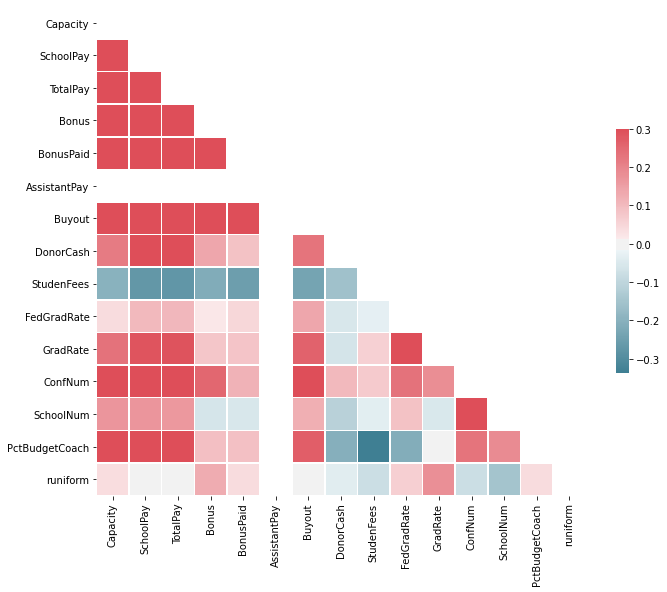

In [37]:
corr = coachSalary.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


References